# Geometrical Methods in Machine Learning
## Seminar 1: PCA

In [1]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from math import isclose

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_wine, load_boston, fetch_olivetti_faces, fetch_openml
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

/Users/maxim/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1. Model data

Consider an artificial dataset which is sampled from multivariate normal distribution with covariance matrix $C = \begin{pmatrix} 3 & 1 \\ 1 & 2 \end{pmatrix}$

In [2]:
sample_size = 500

mu = np.zeros(2)
C = np.array([[3,1],[1,2]])
data = np.random.multivariate_normal(mu, C, size=sample_size)

Find true PC components by covariance matrix diagonalization:

$$S_{TRUE} = \mathbf{V}\mathbf{C}\mathbf{V}^-1$$

In [3]:
# find true PC components by covariance matrix diagonalization E = V * L * V^-1
l, V = np.linalg.eig(C)
l, V

(array([3.61803399, 1.38196601]),
 array([[ 0.85065081, -0.52573111],
        [ 0.52573111,  0.85065081]]))

Find principal components using PCA from `scikit-learn`:

In [4]:
# estimate principal components from empirical data
pca = PCA()
pca.fit(data)

eigenvectors = pca.components_
eigenvalues = pca.explained_variance_

print("Eigenvalues:\n", eigenvalues)
print("\nEigenvectors:\n", eigenvectors)

Eigenvalues:
 [3.35012884 1.56377132]

Eigenvectors:
 [[ 0.90091899  0.4339873 ]
 [-0.4339873   0.90091899]]


In [6]:
def plot_principal_components(data, model, scatter=True):
    W_pca = model.components_
    
    if scatter:
        plt.scatter(data[:,0], data[:,1])
    
    plt.plot(data[:,0], -(W_pca[0,0]/W_pca[0,1])*data[:,0], color="c")
    plt.plot(data[:,0], -(W_pca[1,0]/W_pca[1,1])*data[:,0], color="c")

    plt.axis('equal')
    limits = [np.minimum(np.amin(data[:,0]), np.amin(data[:,1]))-0.5,
              np.maximum(np.amax(data[:,0]), np.amax(data[:,1]))+0.5]
    plt.xlim(limits[0],limits[1])
    plt.ylim(limits[0],limits[1])
    plt.draw()

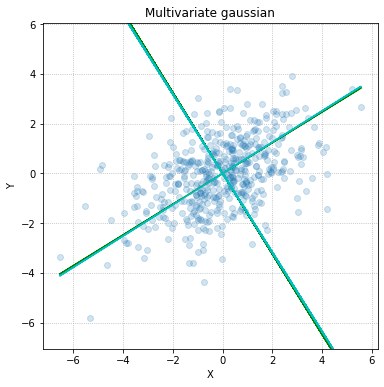

In [7]:
fig = plt.figure(figsize=(6,6))
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.grid(linestyle="dotted")

# plot true principal components
plt.plot(data[:,0], (V[0,0] / V[0,1]) * data[:,0], color="g")
plt.plot(data[:,0], (V[1,0] / V[1,1]) * data[:,0], color="g")

# plot estimated principal components
plot_principal_components(data, pca, scatter=False)

plt.title("Multivariate gaussian")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(data[:,0], data[:,1], alpha=0.2)
plt.show()

#### Exercise

Find principal components manually as SVD solution of PCA problem.

Estimator of covariance matrix of normally distributed variables:

$$\hat{S}_{\mathcal{N}} = \frac{1}{n} (\mathbf{X} - \mathbf{\bar{x}})^T (\mathbf{X} - \mathbf{\bar{x}})$$

In [5]:
# center the data
mean = np.mean(data, axis=0)
data_centered = data - mean

# estimate data covariance matrix, X.T * X
covariance_hat = np.dot(data_centered.T, data_centered) / sample_size

Use SVD `np.linalg.eig` of centered data matrix $\mathbf{X}^T$:

$$\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T$$

In [6]:
# find eigenvalues and eigenvectors of data covariance matrix via SVD

eigenvectors, eigenvalues, _ = np.linalg.svd(data_centered.T)

print("Numerical mean of centered data (should be close zero):\n", mean)
print("\nEstimation of covariance matrix:\n", covariance_hat)
print("\nEigenvectors:\n", eigenvectors)

Numerical mean of centered data (should be close zero):
 [-0.02028093  0.00149618]

Estimation of covariance matrix:
 [[3.00765002 0.69704639]
 [0.69704639 1.89642234]]

Eigenvectors:
 [[-0.90091899 -0.4339873 ]
 [-0.4339873   0.90091899]]


Or eigendecomposition `np.linalg.eig` of covariance matrix $\mathbf{X}^T\mathbf{X}$:

$$\mathbf{X}^T\mathbf{X} = \mathbf{V} \mathbf{\Lambda} \mathbf{V}^{-1}$$

In [7]:
# find eigenvalues and eigenvectors of data covariance matrix via eigendecomposition
eigenvalues, eigenvectors = np.linalg.eig(covariance_hat)

print("Numerical mean of centered data (should be close zero):\n", mean)
print("\nEstimation of covariance matrix:\n", covariance_hat)
print("\nEigenvectors:\n", eigenvectors)

Numerical mean of centered data (should be close zero):
 [-0.02028093  0.00149618]

Estimation of covariance matrix:
 [[3.00765002 0.69704639]
 [0.69704639 1.89642234]]

Eigenvectors:
 [[ 0.90091899 -0.4339873 ]
 [ 0.4339873   0.90091899]]


#### Exercise:

Compute and plot the projection onto the subspace spanned by eigenvectors.

Let $\mathbf{X}$ be $n \times D$ centered data matrix whose columns contain the different observations. Let $\mathbf{V}$ be $D \times d$ matrix whose columns contain $d$ largest eigenvectors. Then the projected data $\mathbf{Z}$ is obtained as projection to the subspace spanned by $d$ largest eigenvectors $\mathbf{Z} = \mathbf{X} \mathbf{V}$.

New basis of data is called eigenbasis. Principal components are axes in the new eigenbasis.

In [8]:
# compute projection to eigenbasis
proj = np.dot(data_centered, eigenvectors)

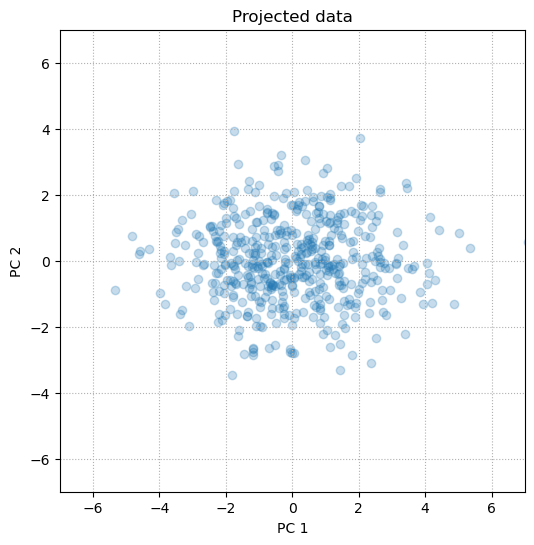

In [9]:
fig = plt.figure(figsize=(6,6))
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.grid(linestyle="dotted")

plt.title("Projected data")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.scatter(proj[:,0], proj[:,1], alpha=0.25)
plt.show()

#### Exercise:

Reduce the dimensionality of the data by the projection onto the subspace spanned by first eigenvector. Plot it.

In [10]:
# reduce the dimensionality of the data
proj = np.dot(data_centered, eigenvectors[:,0])

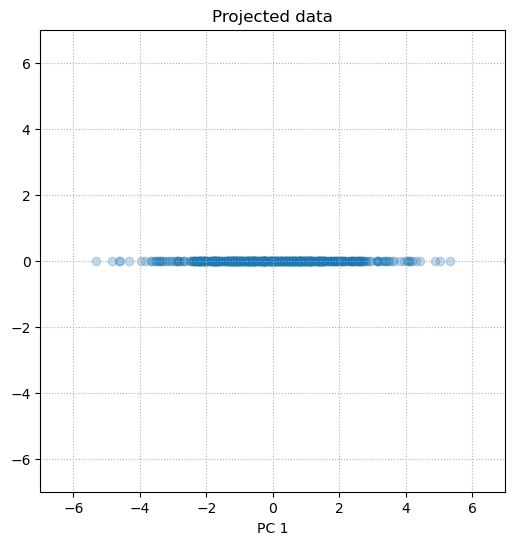

In [11]:
fig = plt.figure(figsize=(6,6))
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.grid(linestyle="dotted")

plt.title("Projected data")
plt.xlabel("PC 1")
plt.scatter(proj, np.zeros(proj.shape[0]), alpha=0.25)
plt.show()

Let $\mathbf{Z}$ be $n \times d$ centered data matrix with $n$ observations with $d$ features with sample mean $\mathbf{\bar{x}}$. Let $\mathbf{V}$ be $D \times d$ projection matrix whose columns contain $d$ largest eigenvectors.

Then PCA reconstruction is defined:

$$\mathbf{\tilde{X}} = \mathbf{Z}\mathbf{V}^T + \mathbf{\bar{x}}$$

#### Exercise:

Reconstuct reduced dimensionality data to original space.

In [12]:
# reconstuct the data
data_reconstructed = np.dot(proj[:, np.newaxis], eigenvectors[:,0][:, np.newaxis].T) + mean

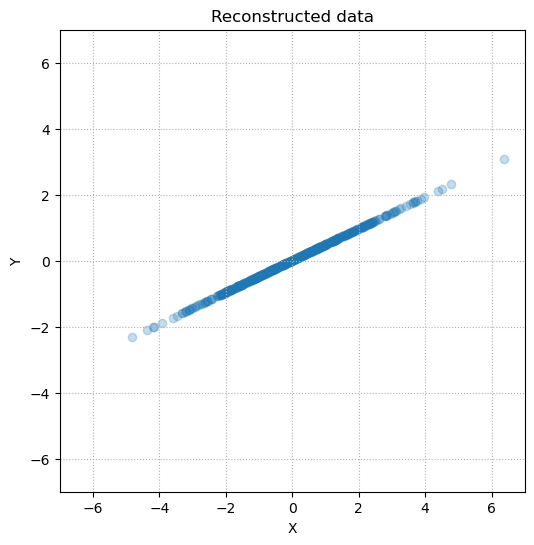

In [13]:
fig = plt.figure(figsize=(6,6))
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.grid(linestyle="dotted")

plt.title("Reconstructed data")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(data_reconstructed[:,0], data_reconstructed[:,1], alpha=0.25)
plt.show()

## 2. Real data

### 2.1 Airfoils

In [14]:
ref_points = np.loadtxt('./data/ref_points.csv', delimiter=',') # X coordinates
X_train = np.loadtxt('./data/airfoils.csv', delimiter=',') # 199 wings
X_test = np.loadtxt('./data/test_afl.csv', delimiter=',') # 200th wing

In [15]:
ref_points

array([1.    , 0.99  , 0.975 , 0.95  , 0.9   , 0.85  , 0.8   , 0.75  ,
       0.7   , 0.65  , 0.6   , 0.55  , 0.5   , 0.45  , 0.4   , 0.35  ,
       0.3   , 0.25  , 0.2   , 0.15  , 0.1   , 0.075 , 0.05  , 0.03  ,
       0.02  , 0.01  , 0.005 , 0.0025, 0.001 , 0.    , 0.001 , 0.0025,
       0.005 , 0.01  , 0.02  , 0.03  , 0.05  , 0.075 , 0.1   , 0.15  ,
       0.2   , 0.25  , 0.3   , 0.35  , 0.4   , 0.45  , 0.5   , 0.55  ,
       0.6   , 0.65  , 0.7   , 0.75  , 0.8   , 0.85  , 0.9   , 0.95  ,
       0.975 , 0.99  , 1.    ])

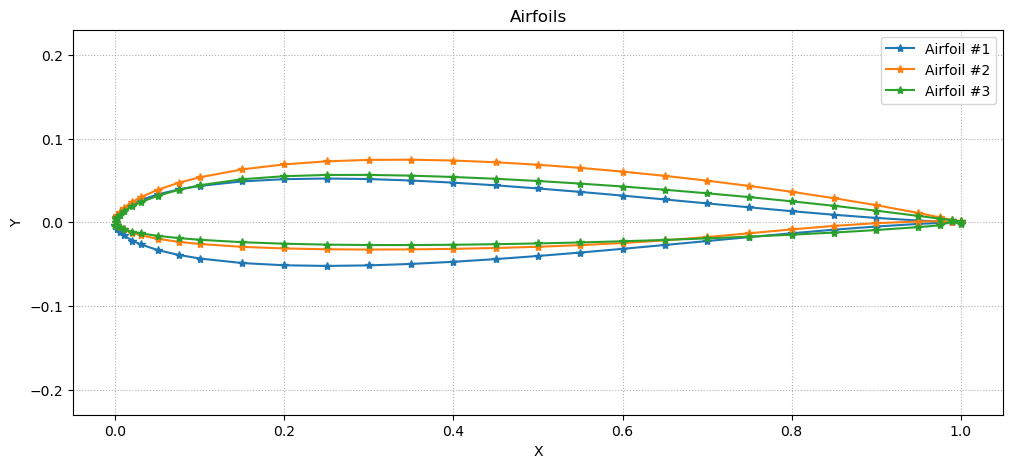

In [17]:
fig = plt.figure(figsize=(12,5))
plt.ylim(-0.23, 0.23)
plt.grid(linestyle="dotted")

#plt.plot(ref_points, test_point, '-*', label = 'Original test')
plt.plot(ref_points, X_train[0, :], '-*', label = 'Airfoil #1')
plt.plot(ref_points, X_train[1, :], '-*', label = 'Airfoil #2')
plt.plot(ref_points, X_train[2, :], '-*', label = 'Airfoil #3')
#plt.plot(ref_points, test_point, label = 'Original')

plt.title("Airfoils")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(['Airfoil #1', 'Airfoil #2', 'Airfoil #3'])

### Airfoils principal components

#### Exercise  
Plot eigenvectors for the 5 largest and 5 smallest eigenvalues

In [18]:
# apply PCA
pca = PCA()
pca.fit(X_train)

# your code here
components = pca.components_

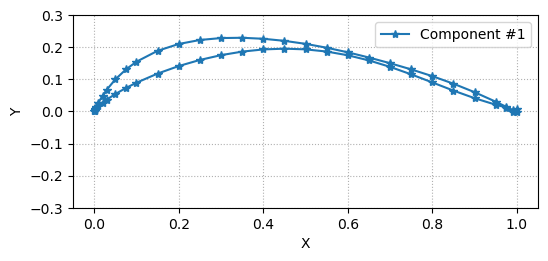

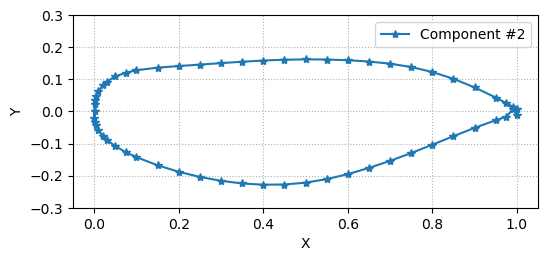

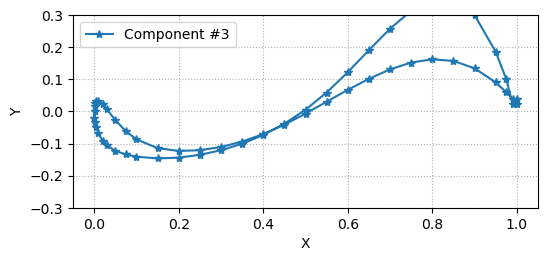

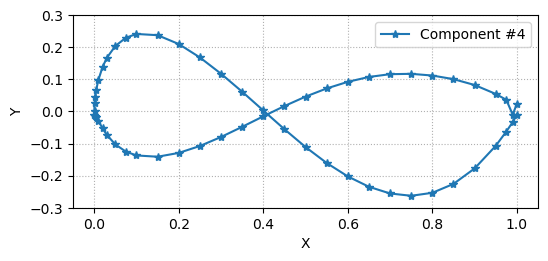

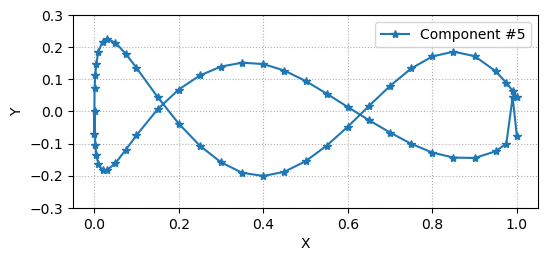

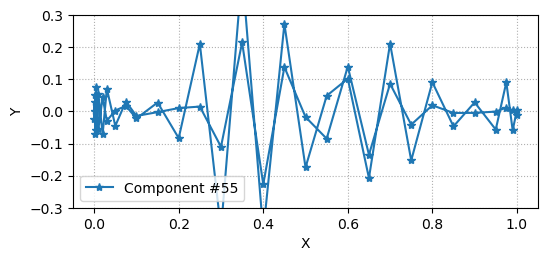

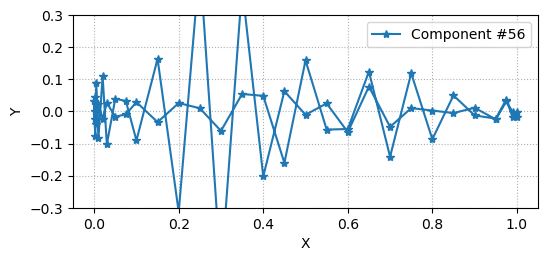

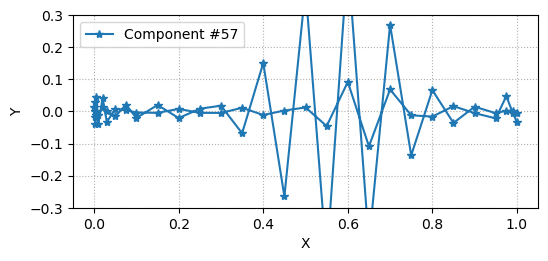

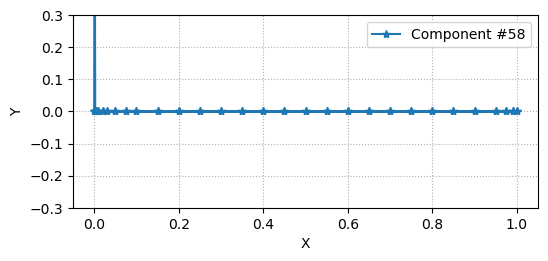

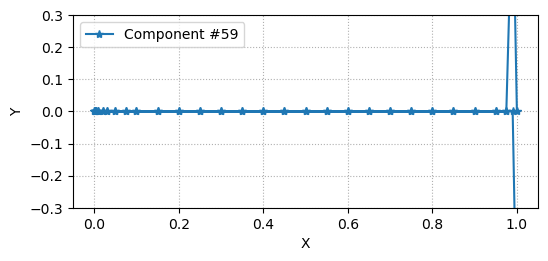

In [19]:
for i in range(5):
    fig = plt.figure(figsize=(6,2.5))
    plt.ylim(-0.3, 0.3)
    plt.grid(linestyle="dotted")
    plt.plot(ref_points, pca.components_[i, :], '-*')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(['Component #{}'.format(i+1)])
    plt.show()
    
for i in range(len(pca.components_) - 5, len(pca.components_)):
    fig = plt.figure(figsize=(6,2.5))
    plt.ylim(-0.3, 0.3)
    plt.grid(linestyle="dotted")
    plt.plot(ref_points, pca.components_[i, :], '-*')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(['Component #{}'.format(i+1)])
    plt.show()

Explained variance of $i$-th principal component is the ratio of corresponding eigenvalue to the sum of all eigenvalues:

$$\mathrm{EV_i} := \frac{\lambda_i}{\lambda_1 + \dots + \lambda_D} = \frac{\lambda_i}{\sum_{j=1}^{D} \lambda_j}$$

Cumulative explained variance of the first $d$ principal components is the ratio of the sum of corresponding eigenvalues to the sum of all eigenvalues:

$$\mathrm{CEV_d} := \frac{\sum_{i=1}^{d} \lambda_i}{\sum_{j=1}^{D} \lambda_j}$$

#### Exercise

Plot expained variance and cumulative explained variance for all $D$ principal components, choose sample dimensionality, state the rule used.

In [20]:
def EV_i(i, eigenvalues):
    return eigenvalues[i] / np.sum(eigenvalues)

In [21]:
def CEV_d(d, eigenvalues):
    eigenvalues_d_sum = 0
    for i in range(d):
        eigenvalues_d_sum += eigenvalues[i]
    return eigenvalues_d_sum / np.sum(eigenvalues)

In [22]:
EV = []
CEV = []

for i in range(X_train.shape[1]):
    EV.append(EV_i(i, pca.explained_variance_))
    CEV.append(CEV_d(i, pca.explained_variance_))

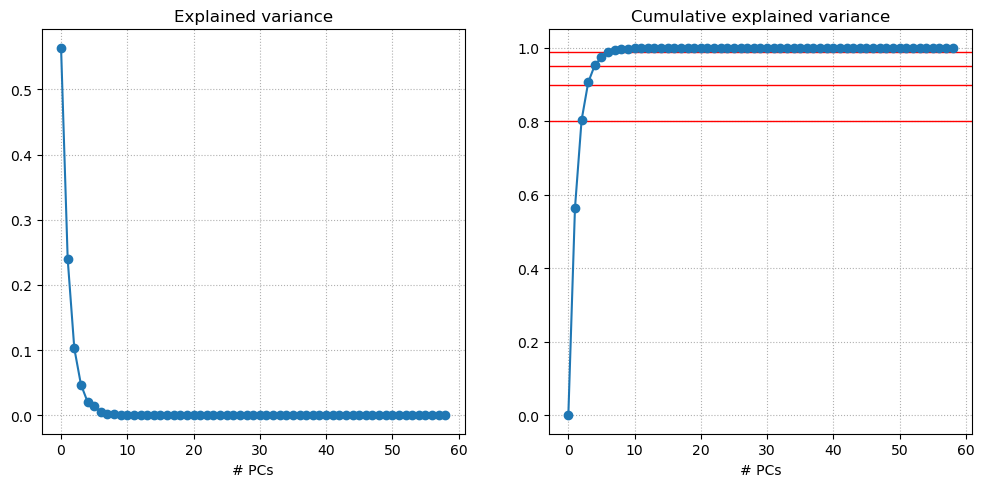

In [23]:
# plot EV/CEVs
fig = plt.figure(figsize=(12,5.25))

plt.subplot(121)
plt.title("Explained variance")
plt.xlabel("# PCs")
plt.grid(linestyle="dotted")
plt.plot(EV, "o-")

plt.subplot(122)
plt.title("Cumulative explained variance")
plt.axhline(linewidth=1, y=0.99, color='r')
plt.axhline(linewidth=1, y=0.95, color='r')
plt.axhline(linewidth=1, y=0.9, color='r')
plt.axhline(linewidth=1, y=0.8, color='r')
plt.xlabel("# PCs")
plt.grid(linestyle="dotted")
plt.plot(CEV, "o-")

#### Exercise 
Describe original airfoil vector in eigenbasis and reproject back for visualization. Try different number of basis eigenvectors.

In [24]:
# apply PCA
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train)
eigenvectors = pca.components_
sample_mean = np.mean(X_train, axis=0)

# your code here
X_test_pcs = np.dot(np.dot(X_test - sample_mean, eigenvectors.T), eigenvectors) + sample_mean

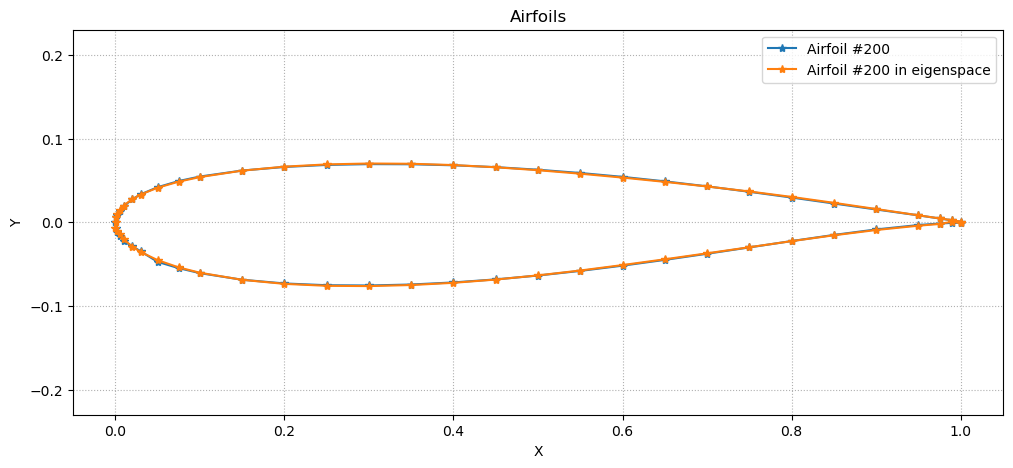

In [25]:
fig = plt.figure(figsize=(12,5))
plt.ylim(-0.23, 0.23)
plt.grid(linestyle="dotted")

#plt.plot(ref_points, test_point, '-*', label = 'Original test')
plt.plot(ref_points, X_test, '-*', label = 'Airfoil #200')
plt.plot(ref_points, X_test_pcs, '-*', label = 'Airfoil #200 in eigenspace')

plt.title("Airfoils")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(['Airfoil #200', 'Airfoil #200 in eigenspace'])

#### Exercise 
Measure reconstruction loss of out-of-sample airfoil `X_test` with different number of principal components in terms of 2-norm, conclude.

In [26]:
# apply PCA
norms = []

for n in range(X_train.shape[1]):
    pca = PCA(n_components=(n+1))
    X_train_pca = pca.fit_transform(X_train)
    eigenvectors = pca.components_
    
    sample_mean = X_train.mean(axis=0)
    X_test_pcs = np.dot(np.dot(X_test - sample_mean, eigenvectors.T), eigenvectors) + sample_mean
    
    norm = np.linalg.norm(X_test - X_test_pcs)
    norms.append(norm)

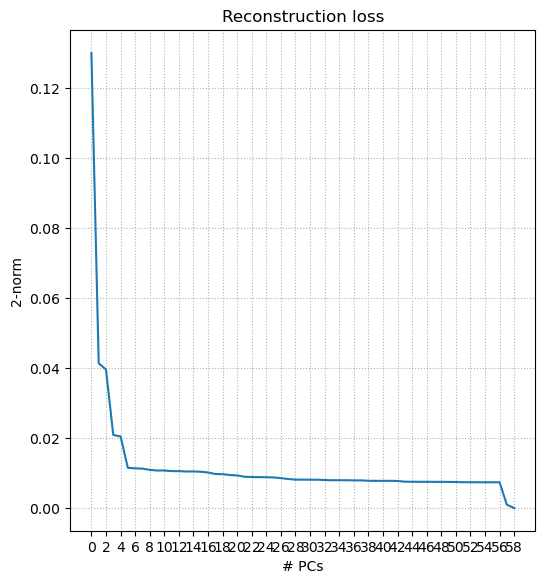

In [32]:
fig = plt.figure(figsize=(6,6.5))

plt.xticks(range(len(norms))[::2])

plt.title("Reconstruction loss")
plt.grid(linestyle="dotted")
plt.plot(norms)
plt.xlabel("# PCs")
plt.ylabel("2-norm")
plt.show()

### 2.2. MNIST

In [ ]:
mnist = fetch_openml('mnist_784', version=1)

In [43]:
train_size = 60000

a_data = np.array(mnist.data)
a_target = np.array(mnist.target)

X_train, X_test, y_train, y_train = a_data[:train_size,:], a_data[train_size:,:], \
a_target[:train_size], a_target[train_size:]

print("Dataset summary:\nSamples: {}, features: {}, classes: {}"
      .format(X_train.shape[0] + X_test.shape[0], X_train.shape[1], np.unique(y_train).shape[0]))

Dataset summary:
Samples: 70000, features: 784, classes: 10


In [44]:
# apply PCA
pca = PCA()
pca.fit(X_train)

PCA()

#### Exercise

Plot expained and cumulative explained variance, choose sample dimensionality, state the rule used

In [45]:
EV = pca.explained_variance_ratio_
CEV = np.cumsum(EV)

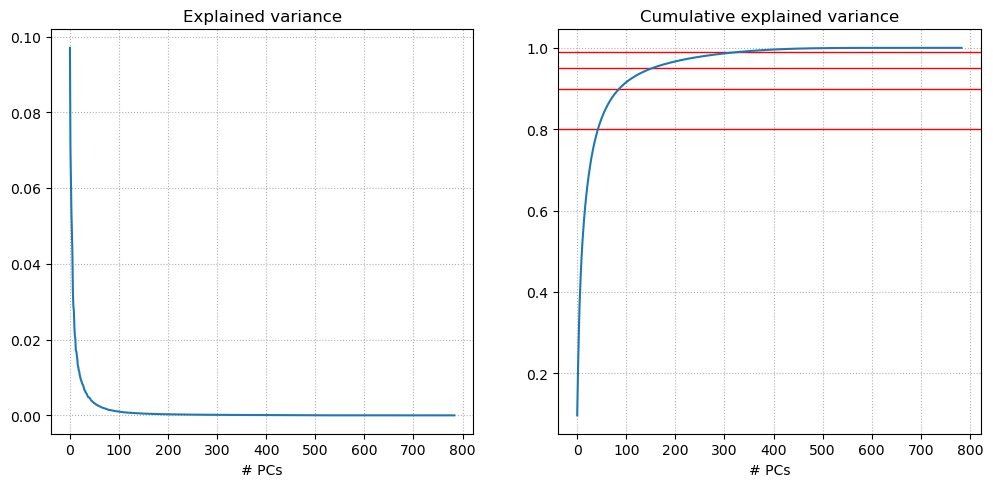

In [46]:
# plot EV/CEVs
fig = plt.figure(figsize=(12,5.25))

plt.subplot(121)
plt.title("Explained variance")
plt.xlabel("# PCs")
plt.grid(linestyle="dotted")
plt.plot(EV)

plt.subplot(122)
plt.title("Cumulative explained variance")
plt.xlabel("# PCs")
plt.grid(linestyle="dotted")
plt.axhline(linewidth=1, y=0.99, color='r')
plt.axhline(linewidth=1, y=0.95, color='r')
plt.axhline(linewidth=1, y=0.9, color='r')
plt.axhline(linewidth=1, y=0.8, color='r')
plt.plot(CEV)

Choose one of the digits $0 \dots 9$ and encode it in terms of different number of principal compoments.

In [47]:
# apply PCA
pca = PCA(n_components=16)
pca.fit(X_train)
eigenvectors = pca.components_

EV = pca.explained_variance_ratio_
CEV = np.cumsum(pca.explained_variance_ratio_)

In [48]:
# encode vector in eigenbasis
sample_mean = X_train.mean(axis=0)
X_test_pcs = np.dot(np.dot(X_test - sample_mean, eigenvectors.T), eigenvectors) + sample_mean

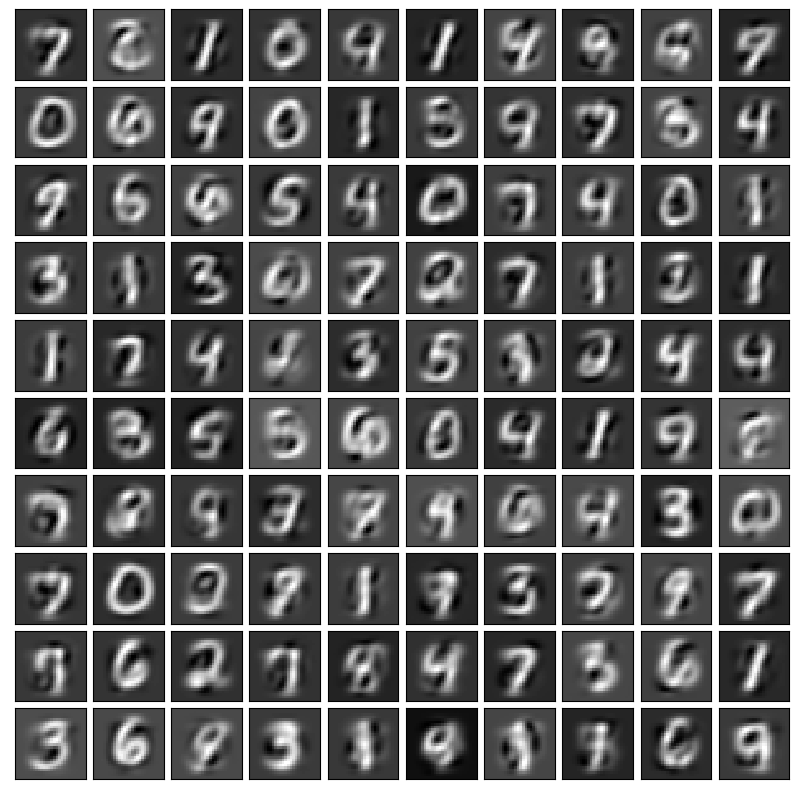

In [49]:
# plot numbers
shape = (28, 28)
_, ax = plt.subplots(10, 10, figsize=(10, 10),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, a in enumerate(ax.flat):
    a.imshow(X_test_pcs[i].reshape(shape), cmap=plt.cm.gray, interpolation="nearest")

#### Exercise 
Measure reconstruction loss of chosen digit within test data `X_test` with different number of principal components in terms of mean 2-norm and PSNR metric.

PSNR gives the ratio between the maximum possible power of a signal and the power of corrupting noise in decibels between image and its noisy approximation:

$$\textrm{PSNR}(x, y) := 20\log_{10} \left( \frac{MAX_I}{\sqrt{MSE}} \right) = 20\log_{10} \left( \frac{MAX_I}{\sqrt{\frac{1}{n} \sum (x - y)^2}} \right)$$

where $MAX_I$ is the maximum possible pixel value of the image. In our case it is 255.

In [52]:
def psnr(x, y):
    mse = np.mean((x - y) ** 2)
    return 20 * np.log10(255 / mse)

In [ ]:
norms = []
psnrs = []

range(2)

for n in list(map(lambda x: 2 ** x, range(10))):
    print("N", n)
    pca = PCA(n_components=(n+1))
    X_train_pca = pca.fit_transform(X_train)
    eigenvectors = pca.components_
    
    sample_mean = X_train.mean(axis=0)
    X_test_pcs = np.dot(np.dot(X_test - sample_mean, eigenvectors.T), eigenvectors) + sample_mean
    
    norm = # your code here
    psnr_metric = # your code here
    
    norms.append(norm)
    psnrs.append(psnr_metric)

In [ ]:
fig = plt.figure(figsize=(6,6.5))
plt.title("Reconstruction loss")
plt.grid(linestyle="dotted")
plt.plot(norms)
plt.xlabel("# PCs")
plt.ylabel("2-norm")
plt.show()

## 3. PCs interpretation

### 3.1. US arrests

In [56]:
# load data
X_arrests = np.loadtxt("./data/usarrests.csv", delimiter=",", skiprows=1, usecols=(1,2,3,4))
targets = list(np.genfromtxt('./data/usarrests.csv', delimiter=',', dtype='str', skip_header=True)[:,0])
y_arrests = [ x.replace('"', '') for x in targets ]
features_arrest = list(np.genfromtxt('./data/usarrests.csv', delimiter=',', dtype='str', skip_header=False)[0,1:])
features_arrest = [ x.replace('"', '') for x in features_arrest ]
#X_arrests, y_arrests

#### Exercise

Standartize data to zero mean and unit variance with `StandardScaler`

In [57]:
# standartize data to zero mean and unit variance
X_arrests_std = StandardScaler().fit_transform(X_arrests)

In [58]:
pca = PCA()
pca.fit(X_arrests_std)

PCA()

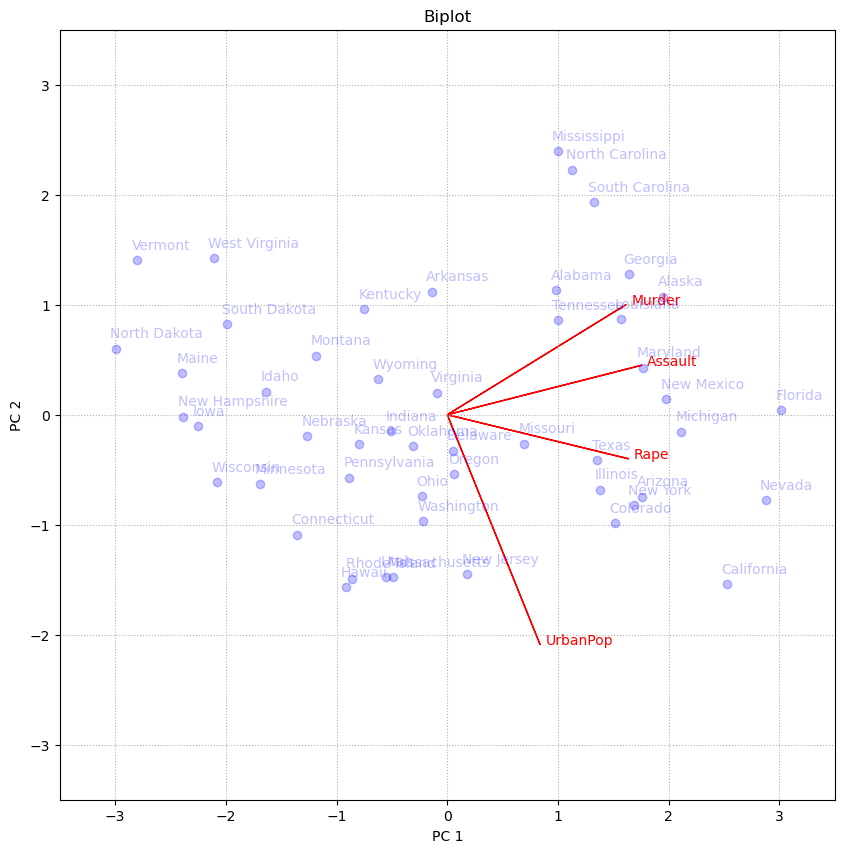

In [64]:
# set eigenvectors to project data to
pc1, pc2 = 0, 1
eigenvector_x = pca.components_[pc1]
eigenvector_y = pca.components_[pc2]

# project data into PC space
xs = pca.transform(X_arrests_std)[:,pc1]
ys = pca.transform(X_arrests_std)[:,pc2]

# visualize projections
plt.figure(figsize=(10,10))

# arrows project features (ie columns from csv) as vectors onto PC axes
for i in range(eigenvector_x.shape[0]):
    plt.arrow(0, 0, eigenvector_x[i] * max(xs), eigenvector_y[i] * max(ys), color='r', width=0.0005)
    plt.text(eigenvector_x[i] * max(xs) + 0.05, eigenvector_y[i] * max(ys), features_arrest[i], color='r')

# circles project documents (ie rows from csv) as points onto PC axes
for i in range(xs.shape[0]):
    plt.plot(xs[i], ys[i], 'bo', alpha=0.25)
    plt.text(xs[i] - 0.05, ys[i] + 0.1, y_arrests[i], color='b', alpha=0.25)

plt.title("Biplot")
plt.xlabel("PC " + str(pc1 + 1))
plt.ylabel("PC " + str(pc2 + 1))
plt.xlim((-3.5, 3.5))
plt.ylim((-3.5, 3.5))
plt.grid(linestyle="dotted")
plt.show()

### 3.2. Wine dataset

In [65]:
wine = load_wine()
X_wine = wine.data
y_wine = wine.target
features_wine = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
# X_wine, y_wine, features_wine

In [66]:
X_wine_std = StandardScaler().fit_transform(X_wine)

pca = PCA()
pca.fit(X_wine_std)

PCA()

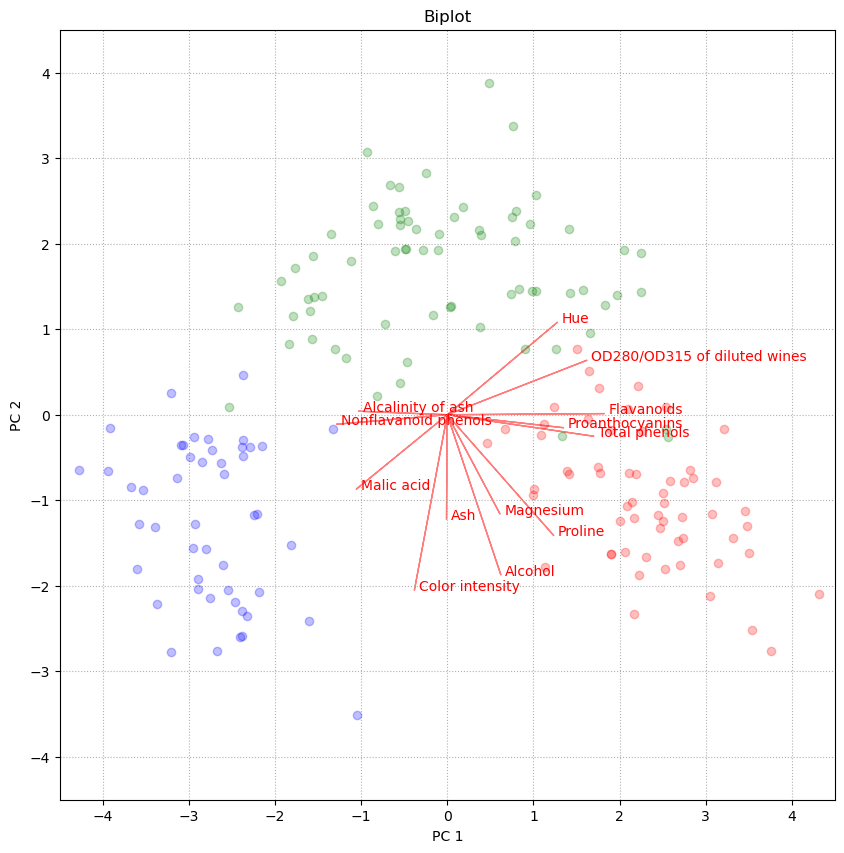

In [67]:
# set eigenvectors to project data to
pc1, pc2 = 0, 1
eigenvector_x = pca.components_[pc1]
eigenvector_y = pca.components_[pc2]

# project data into PC space
xs = pca.transform(X_wine_std)[:,pc1]
ys = pca.transform(X_wine_std)[:,pc2]

# visualize projections
plt.figure(figsize=(10,10))

# arrows project features (ie columns from csv) as vectors onto PC axes
for i in range(eigenvector_x.shape[0]):
    plt.arrow(0, 0, eigenvector_x[i] * max(xs), eigenvector_y[i] * max(ys), color='r', width=0.0005, alpha=0.5)
    plt.text(eigenvector_x[i] * max(xs) + 0.05, eigenvector_y[i] * max(ys), features_wine[i], color='r')

colors = ['r', 'g', 'b']
# circles project documents (ie rows from csv) as points onto PC axes
for i in range(xs.shape[0]):
    plt.plot(xs[i], ys[i], 'o', color=colors[y_wine[i]], alpha=0.25)

plt.title("Biplot")
plt.xlabel("PC " + str(pc1 + 1))
plt.ylabel("PC " + str(pc2 + 1))
plt.xlim((-4.5, 4.5))
plt.ylim((-4.5, 4.5))
plt.grid(linestyle="dotted")
plt.show()

## 4. PCA for decision making

- high-dimensional space is more dangerous to overfit complex models, than simple ones
- PC are orthogonal, decorellated features
    - may improve linear classifiers, if data multicolinearity problem
    - for complex decision boundaries classifiers, they can be a problem in even lower dimensions
- variable scaling, ensure your data is scaled to isotropic Gaussian $\sim \mathcal{N}(0, 1)$ or at least have similar scale (`MinMaxScaler`)
- you can estimate first $q$ PCs only, using iterative optimization, instead full eigenvalue/SVD decoposition and then taking top PC corresponing to largest eigenvalues

### 4.1. Eigenfaces

Eigenfaces as principal compoments and logistic regression classification

In [68]:
# load Olivetti faces dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

dataset = fetch_olivetti_faces(shuffle=True, random_state=1)
train_size = 350
X_train, X_test, y_train, y_test = dataset.data[:train_size,:], dataset.data[train_size:,:], dataset.target[:train_size], dataset.target[train_size:]
shape = (64, 64)
print("Dataset summary:\nSamples: {}, features: {}, classes: {}".format(dataset.data.shape[0], dataset.data.shape[1], np.unique(dataset.target).shape[0]))


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/maxim/scikit_learn_data
Dataset summary:
Samples: 400, features: 4096, classes: 40


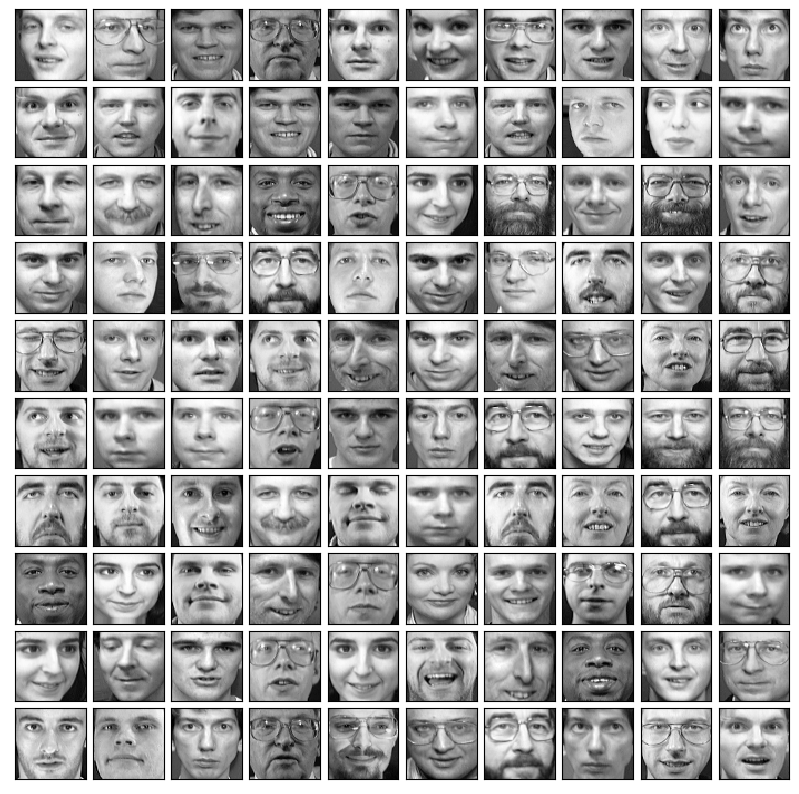

In [69]:
# plot faces
_, ax = plt.subplots(10, 10, figsize=(10, 10),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, a in enumerate(ax.flat):
    a.imshow(X_train[i].reshape(shape), cmap=plt.cm.gray, interpolation="nearest")

#### Exercise

Plot first 64 eigenfaces, comment the difference between the first and the last ones

In [70]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

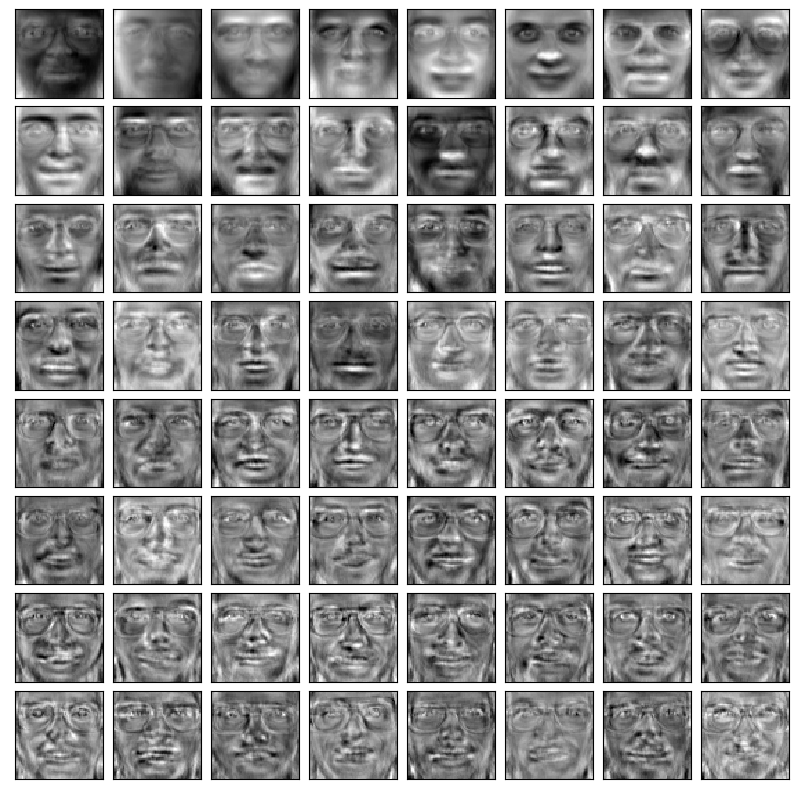

In [71]:
# plot first 64 components
_, ax = plt.subplots(8, 8, figsize=(10, 10),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, a in enumerate(ax.flat):
    a.imshow(pca.components_[i].reshape(shape), cmap=plt.cm.gray, interpolation="nearest")

#### Exercise
Encode any face in test dataset in eigenbasis of different powers, `n_components`= [2, 4, 8 16, 32, 64, $\dots$]

In [72]:
# apply PCA
face_id = 1
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
eigenvectors = pca.components_

sample_mean = X_train.mean(axis=0)
X_test_pcs = np.dot(np.dot(X_test[face_id] - sample_mean, eigenvectors.T), eigenvectors) + sample_mean

In [73]:
X_train_pca.shape

(350, 2)

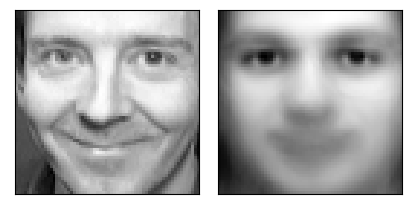

In [74]:
# plot
_, ax = plt.subplots(1, 2, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

ax[0].imshow(X_test[face_id].reshape(shape), cmap=plt.cm.gray, interpolation="nearest")
ax[1].imshow(X_test_pcs.reshape(shape), cmap=plt.cm.gray, interpolation="nearest")

#### Exercise 
Classify faces in original dimension with kNN, logistic regression and random forest, conclude.

In [75]:
from sklearn.metrics import accuracy_score 

clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(X_train, y_train)

acc_full_train = accuracy_score(clf.predict(X_train), y_train)
acc_full_test = accuracy_score(clf.predict(X_test), y_test)

acc_full_train, acc_full_test

(0.9142857142857143, 0.78)

#### Exercise

Perform classification in the space of reduced dimension of your choice, conclude.

In [76]:
n_components = 32

pca = PCA(n_components=n_components)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(X_train_pca, y_train)
accuracy_score(clf.predict(X_train_pca), y_train), accuracy_score(clf.predict(X_test_pca), y_test)

(0.9057142857142857, 0.84)

#### Exercise

- Perform classification for a whole range of dimensions, with a classifier of your choice.
- State the maximum number of principal components for this space, conclude. 
- Plot the classification performance.

In [ ]:
acc_train = []
acc_test = []

for n in range(2, 256, 2):
    
    print("N = {}".format(n))
    pca = PCA(n_components=n)
    pca.fit(X_train)
    
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    clf = KNeighborsClassifier(n_neighbors=7)
    clf.fit(X_train_pca, y_train)
    
    accuracy_train = accuracy_score(clf.predict(X_train_pca), y_train)
    accuracy_test = accuracy_score(clf.predict(X_test_pca), y_test)
    
    acc_train.append(accuracy_train)
    acc_test.append(accuracy_test)

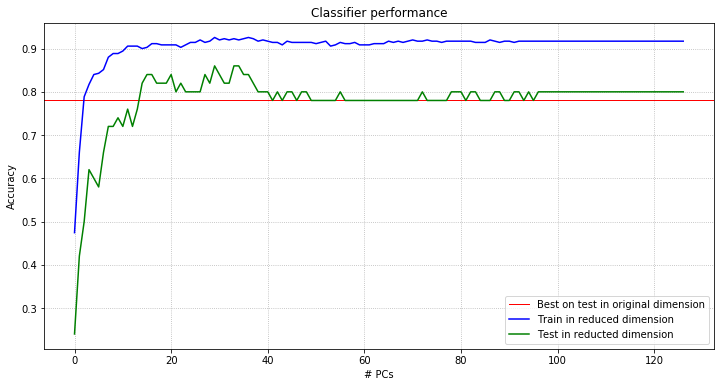

In [58]:
fig = plt.figure(figsize=(12,6))
plt.title("Classifier performance")
plt.xlabel("# PCs")
plt.ylabel("Accuracy")
plt.grid(linestyle="dotted")
plt.axhline(linewidth=1, y=acc_full_test, color='r')
plt.plot(acc_train, 'b')
plt.plot(acc_test, 'g')
plt.legend(['Best on test in original dimension', 'Train in reduced dimension', 'Test in reducted dimension'])
plt.show()